In [9]:
from sklearn.datasets import fetch_mldata
from six.moves import urllib
import numpy as np

In [10]:
try:
    mnist = fetch_mldata('MNIST original')
except urllib.error.HTTPError as ex:
    print("Could not download MNIST data from mldata.org, trying alternative...")

    # Alternative method to load MNIST, if mldata.org is down
    from scipy.io import loadmat
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    mnist_path = "./mnist-original.mat"
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, "wb") as f:
        content = response.read()
        f.write(content)
    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw["data"].T,
        "target": mnist_raw["label"][0],
        "COL_NAMES": ["label", "data"],
        "DESCR": "mldata.org dataset: mnist-original",
    }
    print("Success!")

Could not download MNIST data from mldata.org, trying alternative...
Success!


In [11]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [12]:
X, y = mnist["data"], mnist["target"]

In [13]:
X.shape, y.shape

((70000, 784), (70000,))

In [14]:
%matplotlib inline

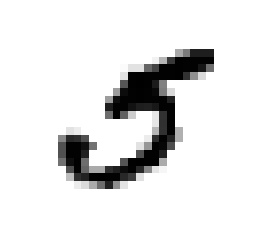

5.0

In [15]:
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap= matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()
y[36000]

In [16]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5) 

In [17]:
print(len(X_train), len(y_train_5))

60000 60000


In [18]:
from sklearn.linear_model import SGDClassifier

In [19]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [20]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))
    
    

0.96545
0.9696
0.96345


In [22]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)



In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53681,   898],
       [ 1132,  4289]])

In [24]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)


0.82687487950645844

In [25]:
recall_score(y_train_5, y_train_pred)

0.79118243866445304

In [26]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.80863499245852188

In [27]:
y_scores = sgd_clf.decision_function([some_digit])

In [28]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [29]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])




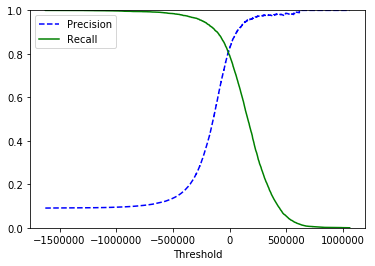

In [30]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()




In [31]:
y_train_pred_90 = (y_scores > 120000)

In [32]:
precision_score(y_train_5, y_train_pred_90)

0.94035192365046227

In [33]:
recall_score(y_train_5, y_train_pred_90)

0.58162700608743778

In [34]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
print(fpr[-1],tpr[-1])

1.0 1.0


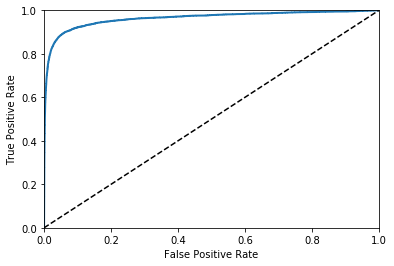

In [35]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()



In [36]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)


0.96334731174085542

In [37]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state = 42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")


In [38]:
y_scores_forest = y_probas_forest[:, 1]
print(y_scores_forest)

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)



[ 0.  0.  0. ...,  0.  0.  0.]


c:\users\admin\anaconda3\envs\handon_ml\lib\site-packages\matplotlib\legend.py:326: UserWarning: Unrecognized location "bottom right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  six.iterkeys(self.codes))))


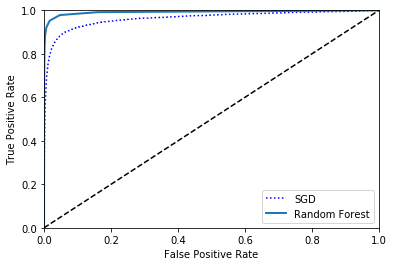

In [39]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="bottom right")
plt.show()



In [40]:
 roc_auc_score(y_train_5, y_scores_forest)

0.99213931519799026

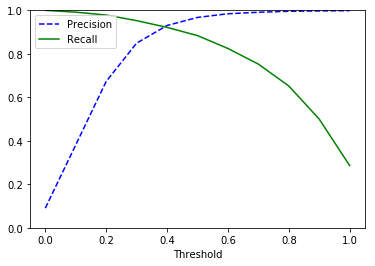

In [41]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores_forest)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()
print()

In [42]:
y_preds_forest = list(map(lambda x: x >= 0.5, y_scores_forest))

In [43]:
print("precision",precision_score(y_train_5, y_preds_forest))
print("recall", recall_score(y_train_5, y_preds_forest))

precision 0.967494447809
recall 0.883969747279


### Multiclass Classification

In [44]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [45]:
sgd_clf.predict([some_digit])
some_digit_scores = sgd_clf.decision_function([some_digit])

In [46]:
some_digit_scores

array([[ -97823.71683321, -482773.45998467, -133381.84247304,
        -270557.19233539, -471823.95754091,   50246.7061842 ,
        -792599.24313548, -496650.03260539, -708057.08529713,
        -730341.28996395]])

In [47]:
np.argmax(some_digit_scores)

5

In [48]:
sgd_clf

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")


array([ 0.90896821,  0.90889544,  0.91228684])

In [50]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx




array([[5734,    2,   21,    7,   12,   48,   43,   11,   41,    4],
       [   2, 6500,   41,   23,    6,   39,    7,    9,  103,   12],
       [  57,   42, 5314,   95,   86,   25,   97,   57,  171,   14],
       [  44,   43,  131, 5320,    1,  249,   40,   54,  146,  103],
       [  20,   24,   37,   10, 5356,    8,   53,   28,   74,  232],
       [  70,   43,   30,  167,   73, 4628,  115,   28,  164,  103],
       [  34,   28,   39,    2,   51,   84, 5631,    4,   45,    0],
       [  24,   19,   62,   30,   57,   11,    7, 5779,   14,  262],
       [  56,  149,   58,  150,   12,  162,   56,   32, 5027,  149],
       [  45,   29,   23,   86,  142,   25,    3,  201,   81, 5314]])

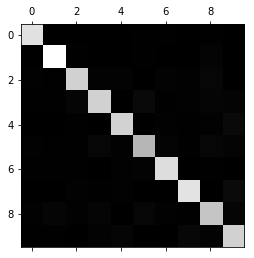

In [51]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [52]:
row_sums = conf_mx.sum(axis=1, keepdims=True)

In [53]:
norm_conf_mx = conf_mx / row_sums

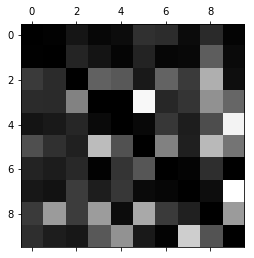

In [54]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()



In [55]:
norm_conf_mx

array([[ 0.        ,  0.00033767,  0.0035455 ,  0.00118183,  0.002026  ,
         0.008104  ,  0.00725983,  0.00185717,  0.00692217,  0.00067533],
       [ 0.00029665,  0.        ,  0.00608128,  0.00341145,  0.00088994,
         0.00578463,  0.00103827,  0.00133492,  0.01527737,  0.00177989],
       [ 0.00956697,  0.00704935,  0.        ,  0.01594495,  0.01443437,
         0.00419604,  0.01628063,  0.00956697,  0.02870091,  0.00234978],
       [ 0.00717664,  0.00701354,  0.02136682,  0.        ,  0.00016311,
         0.04061328,  0.00652422,  0.0088077 ,  0.02381341,  0.01679987],
       [ 0.00342349,  0.00410818,  0.00633345,  0.00171174,  0.        ,
         0.00136939,  0.00907224,  0.00479288,  0.01266689,  0.03971243],
       [ 0.01291275,  0.00793212,  0.00553403,  0.03080612,  0.01346615,
         0.        ,  0.0212138 ,  0.0051651 ,  0.03025272,  0.01900018],
       [ 0.00574518,  0.00473133,  0.00659006,  0.00033795,  0.00861778,
         0.01419398,  0.        ,  0.0006759 

In [56]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]




NameError: name 'plot_digits' is not defined

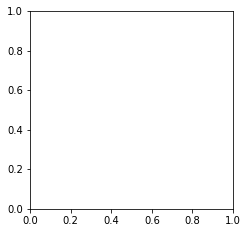

In [58]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [{'n_neighbors': [4000], 'weights': [ 'distance']}]

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()

grid_search = GridSearchCV(knn_clf, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)

grid_search.fit(X_train, y_train)



Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
knn_clf.predict([some_digit])


In [60]:
noise = rnd.randint(0, 100, (len(X_train)), 784)
noise = rnd.randint(0, 100, (len(X_test)), 784)
X_train_mod = X_train + noise
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

NameError: name 'randint' is not defined

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
knn_clf.predict([])

### Exercises

In [67]:
X_train, y_train

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([ 7.,  8.,  4., ...,  7.,  8.,  9.]))